## Import the required libraries

In [1]:
# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

# For data processing
import numpy as np
import pandas as pd

# For clustering and dimensionality reduction
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap.umap_ as umap
from scipy.spatial.distance import cdist

# Plotly imports
import plotly.graph_objects as go
from plotly.offline import plot

# For Parallel Computing
from joblib import Parallel, delayed

# For evaluation and visualization
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score, normalized_mutual_info_score
from tqdm import tqdm
import pickle

## Load the pickle files containing the Embeddings

#### **Efficient Management of Large-Scale Embeddings via Segmentation Optimized Loading of Segmented Embeddings**

**Segmentation Strategy:** To manage the extensive volume of embeddings, the dataset is divided into five segments, enabling more efficient processing and handling within the constraints of system memory and computational resources.

**Procedure Description:**
Given the enormity of our dataset, direct extraction of embeddings for the entire set proved impractical. To circumvent this, we divided the embedding process into five distinct batches, each serialized into its pickle file. This modular approach not only mitigates memory overload but also introduces flexibility and scalability to the workflow.

The code establishes a clear mapping of file paths to their respective dataset segments, followed by the load_dataset function, which efficiently retrieves the stored embeddings. Subsequently, each segment is loaded into its variable, ready to be amalgamated for dimensionality reduction.

This careful planning and segmented processing exemplify an effective solution to the challenges posed by large datasets, ensuring that the subsequent steps, such as dimension reduction and clustering, are based on a complete and integrated set of data embeddings. This approach is particularly crucial in chemical research, where the richness of data must be preserved through every step of the analytical process.


In [3]:
# Paths to the Embedding files
datasets_paths = {
    'cond_mat_embeddings_with_ids_5000':'cond_mat_embeddings_with_ids_5000.pickle',
    'cond_mat_embeddings_with_ids_10000':'cond_mat_embeddings_with_ids_10000.pickle',
    'cond_mat_embeddings_with_ids_16000': 'cond_mat_embeddings_with_ids_16000.pickle',
    'cond_mat_embeddings_with_ids_16001_21000': 'cond_mat_embeddings_with_ids_16001_21000.pickle',
    'cond_mat_embeddings_with_ids_21001_25000': 'cond_mat_embeddings_with_ids_21001_25000.pickle',
}

# Function to load a dataset
def load_dataset(file_path):       #Systematic Loading
    with open(file_path, 'rb') as file:
        return pickle.load(file)

# Load the datasets

cond_mat_embeddings_with_ids_5000 = load_dataset(datasets_paths["cond_mat_embeddings_with_ids_5000"])
cond_mat_embeddings_with_ids_10000 = load_dataset(datasets_paths["cond_mat_embeddings_with_ids_10000"])
cond_mat_embeddings_with_ids_16000 = load_dataset(datasets_paths["cond_mat_embeddings_with_ids_16000"])
cond_mat_embeddings_with_ids_16001_21000 = load_dataset(datasets_paths["cond_mat_embeddings_with_ids_16001_21000"])
cond_mat_embeddings_with_ids_21001_25000 = load_dataset(datasets_paths["cond_mat_embeddings_with_ids_21001_25000"])

## Analsye the Embeddings

### **Consolidation and Analysis of Chemical Embedding Dimensions**

Unifying Segmented Embedding Data

Dataset Merging: The individual segments of embeddings are combined into a single merged list, facilitating holistic analysis.
Dataset Overview: We compute and present a summary of the unified embeddings, detailing the number of documents and features.
Analysis Description:
Upon the successful segmentation and serialization of our embeddings, the next logical step involves the merging of these segmented data points to form a cohesive dataset. This merging is pivotal as it reintegrates the previously partitioned data, ensuring that our analysis is reflective of the dataset in its entirety.

The code in question elegantly handles this task by concatenating the data lists from two segments, creating a merged dataset that retains all the embeddings. This unified dataset is then succinctly summarized to provide an overview; it reports that the dataset encompasses 8,998 documents, each represented by 768 features.

This dimensional footprint of the embeddings, encapsulated by the 768 features, corresponds to the encoded linguistic and semantic characteristics captured by the BERT model. The number of documents signifies the breadth of the dataset now prepared for downstream tasks such as clustering or predictive modeling.

By analyzing the size and shape of our embedding space, we lay the groundwork for understanding the complexity and variability within our corpus. This insight is crucial for guiding subsequent data-driven decisions, allowing us to tailor our modeling approaches to the specific contours of our chemical language dataset. The careful reassembly and analysis of the segmented embeddings ensure that we maintain the integrity and richness of the data as we progress towards more advanced stages of our study.

In [16]:
# Merge the datasets
merged_data_list = cond_mat_embeddings_with_ids_5000['data'] + cond_mat_embeddings_with_ids_10000['data'] + cond_mat_embeddings_with_ids_16000['data'] + cond_mat_embeddings_with_ids_16001_21000['data'] + cond_mat_embeddings_with_ids_21001_25000['data']  
embeddings_data = {'data': merged_data_list}

In [17]:
# Print dataset information
num_docs = len(embeddings_data['data'])
num_features = len(embeddings_data['data'][0]['embedding'])
print(f">> The Embedding Dataset has {num_docs} documents and {num_features} features.")

>> The Embedding Dataset has 24996 documents and 768 features.


## `Dimensionality Reduction` via PCA and `Clustering Analysis` with K-Means

### Comprehensive Evaluation of PCA and K-Means on Chemical Abstracts Embeddings

- The aim is to reduce the dimensionality of the chemical abstracts embeddings to facilitate clustering analysis and enhance interpretability.

- **PCA Implementation:** We deploy Principal Component Analysis (PCA) across a range of dimensions from 2 to 20 principal components` n_components_list = [i for i in range(1, 15)]` to identify the optimal feature subspace.

-**K-Means Clustering:** Utilizing the true number of clusters, informed by the number of unique labels, we apply `K-means clustering` to the reduced embeddings to categorize the documents into meaningful groups.

- **Evaluation Metrics:**

`Normalized Mutual Information (NMI):` Serving as an external validation measure, NMI provides a comparative analysis between our clustering results and the ground truth labels.

`Silhouette Score:` This metric guides the optimal choice of principal components by evaluating the cohesion and separation of the clusters formed at each level of dimensionality reduction.

**Results Visualization:**

We visualize the variance ratio explained by the principal components to understand the information retained post-reduction.

Evaluation metrics such as Silhouette and NMI scores are plotted against the number of principal components to discern the optimal dimensionality for clustering.

In [18]:
def evaluate_pca_kmeans_metrics(dataset_name, embeddings, labels, n_components_list):
    """
    Evaluate PCA and K-means clustering metrics.
    """
    results = {
        'n_components': [],
        'silhouette_score': [],
        'nmi_score': [],
        'explained_variance_ratio': []
    }
    n_clusters = len(set(labels))
    optimal_num_components = None
    max_silhouette_score = -1
    
    for n_components in tqdm(n_components_list, desc=f'Evaluating PCA components fo the {dataset_name} dataset'):
        # Apply PCA
        pca = PCA(n_components=n_components)
        reduced_data = pca.fit_transform(embeddings)
        # Record the percentage of Explained Variance Ratio by the chosen number of components 
        explained_variance_ratio = np.sum(pca.explained_variance_ratio_)
        
        # Apply K-means using the real number of clusters (the labels)
        kmeans = KMeans(n_clusters=n_clusters)
        predicted_labels = kmeans.fit_predict(reduced_data)

        # Calculate the Silhouette Score and the NMI Score
        silhouette_avg = silhouette_score(reduced_data, predicted_labels) 
        nmi = normalized_mutual_info_score(labels, predicted_labels) 

        # Store the results in a dictionary
        results['n_components'].append(n_components)
        results['silhouette_score'].append(silhouette_avg)
        results['nmi_score'].append(nmi)
        results['explained_variance_ratio'].append(explained_variance_ratio)
        
        # Update the optimal number of components based on the silhouette score
        if silhouette_avg > max_silhouette_score:
            max_silhouette_score = silhouette_avg
            optimal_num_components = n_components
    
    return pd.DataFrame(results)

def plot_evaluation_metrics(df_results, dataset_name):
    """
    Plot for evaluation metrics with vertical lines indicating optimal number of principal components.
    """
    # Create a figure with 1 subplot for Silhouette and NMI, and another for Explained Variance Ratio
    fig, (ax1, ax3) = plt.subplots(1, 2, figsize=(14, 7))

    # Subplot for Silhouette and NMI scores
    ax1.set_xlabel('Number of Principal Components')
    ax1.set_ylabel('Score', color='tab:blue')
    ax1.plot(df_results['n_components'], df_results['silhouette_score'], color='tab:blue', marker='o', label='Silhouette Score')
    ax1.plot(df_results['n_components'], df_results['nmi_score'], color='tab:red', marker='x', label='NMI Score')
    ax1.tick_params(axis='y', labelcolor='tab:blue')
    ax1.set_xticks(df_results['n_components'])
    ax1.legend(loc='upper left')
    ax1.grid(True)

    # Add vertical lines for optimal number of components based on Silhouette and NMI scores
    optimal_n_components_silhouette = df_results.loc[df_results['silhouette_score'].idxmax(), 'n_components']
    ax1.axvline(x=optimal_n_components_silhouette, color='tab:green', linestyle='--', label=f'Optimal PCs (Silhouette): {optimal_n_components_silhouette}', alpha=0.7)
    optimal_n_nmi_score = df_results.loc[df_results['nmi_score'].idxmax(), 'n_components']
    ax1.axvline(x=optimal_n_nmi_score, color='tab:orange', linestyle='--', label=f'Optimal PCs (NMI): {optimal_n_nmi_score}', alpha=0.7)

    # Subplot for Explained Variance Ratio
    ax3.set_xlabel('Number of Principal Components')
    ax3.set_ylabel('Explained Variance Ratio', color='tab:green')
    ax3.plot(df_results['n_components'], df_results['explained_variance_ratio'], color='tab:green', marker='^', label='Explained Variance Ratio')
    ax3.tick_params(axis='y', labelcolor='tab:green')
    ax3.set_xticks(df_results['n_components'])  # Ensure x-ticks correspond to the number of components tested
    ax3.legend(loc='upper left')
    ax3.grid(True)

    # Add lines to the legend
    ax1.legend(loc='upper left', bbox_to_anchor=(1, 1), title='Legend', title_fontsize='large')
    plt.suptitle(f'Evaluation Metrics across Principal Components - {dataset_name}')
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to make room for the title
    plt.show()

### Refinement and Assessment of Chemical Abstracts Embeddings via PCA
#### Embedding Extraction and PCA Evaluation Process

##### Procedure Steps:

- **Data Extraction:** The embeddings and labels are first extracted from the embeddings_data dictionary, which houses the data in a structured format.

- **Array Conversion:** The list of embeddings is then converted into a NumPy array, a format suitable for mathematical manipulation and input into machine learning algorithms.

Principal Components Testing: We iterate over a range of principal components, from 1 to 14, to assess the impact of dimensionality reduction on clustering performance.

##### Graphical Analysis and Metrics Interpretation:

The accompanying plots illustrate how varying numbers of principal components affect the clustering metrics, such as Silhouette Score and Normalized Mutual Information (NMI), alongside the explained variance ratio.

The Silhouette Score is depicted in blue, providing insights into the compactness and separation of clusters, with higher scores indicating better-defined clusters.

**`The NMI Score`**, shown in red, measures the clustering outcome's alignment with the true class labels, with higher values suggesting greater accuracy.

**`The Explained Variance Ratio`**, represented in green, indicates the proportion of dataset variance captured by each principal component count.

Selection of Optimal Principal Components:

**`Silhouette Score:`** Indicates that a lower number of principal components may lead to well-separated and distinct clusters.

**`NMI Score:`** Suggests the number of components that achieve clustering most aligned with the true labels.

**Decision Criterion:** The optimal number of principal components is chosen based on a balance between the Silhouette Score and the NMI, ensuring both well-defined cluster structures and alignment with true classifications.

- **Conclusion:**

The analysis provides a clear visual and quantitative guide to selecting the best number of principal components for clustering. It underscores the importance of dimensionality reduction in preparing high-dimensional embedding data for meaningful clustering, facilitating a deeper understanding of the dataset's inherent structure.

In [19]:
# Extract embeddings and labels from the embeddings_data dictionary
embeddings_list = [item['embedding'] for item in embeddings_data['data']]  
labels = [item['label'] for item in embeddings_data['data']]

# Convert the embeddings list to a NumPy array
embeddings = np.array(embeddings_list)

# Define the dataset name
dataset_name = 'Cond Mat'

Evaluating PCA components fo the Cond Mat dataset: 100%|█| 14/14 [03:09<


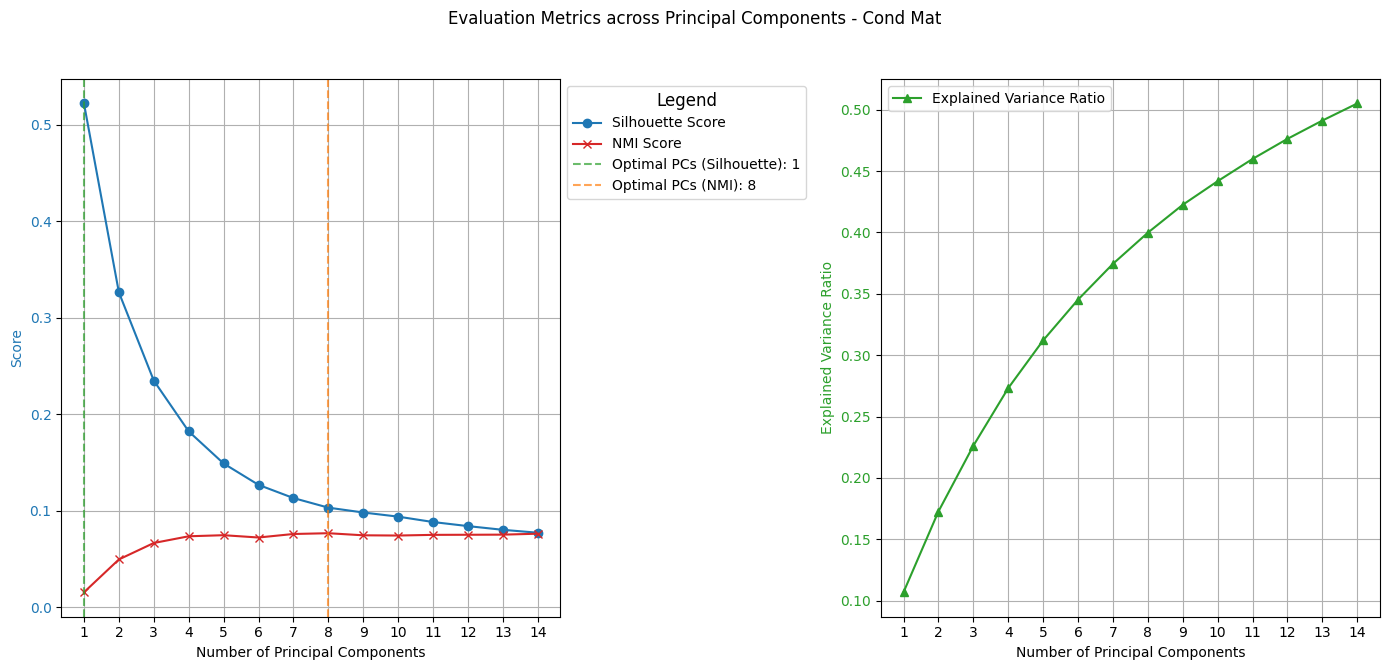

In [20]:
# List of Principal Components to test
n_components_list = [i for i in range(1, 15)]
df_results = evaluate_pca_kmeans_metrics(dataset_name, embeddings, labels, n_components_list)
plot_evaluation_metrics(df_results, dataset_name)

#### Optimal Number of Principal Components Interpretation

- **Silhouette Score**: Higher scores indicate that the clusters are well-separated and distinct.
- **NMI Score**: Higher scores suggest clustering that aligns closely with the true labels.

**Selection Criteria**:
Opt for the number of components that optimally balance both metrics.

**Analysis and Insights:**

The analysis reveals the trade-offs between dimensionality reduction and clustering quality. The optimal number of principal components is determined based on the silhouette score, which signifies the best-defined cluster structure.

The NMI score complements this by indicating the level of agreement between the clustering assignments and the true classifications.

rue classifications.

Concluding Remarks:

The PCA and K-Means clustering provide a two-pronged approach to structuring the high-dimensional embeddings space into a more accessible format that still preserves the underlying patterns and relationships.

This step is critical in our pipeline as it directly impacts the clarity and usefulness of the clustering results, thereby enabling more precise interpretations and conclusions in our subsequent analysis of the chemical documents dataset.


## t-SNE for `Dimensionality Reduction` and K-means for `Clusting`


In this step, we'll utilize **t-distributed Stochastic Neighbor Embedding (t-SNE)** to reduce the dimensionality of the datasets. We'll explore various values of **perplexity** and evaluate their impact. Perplexity directly influences cluster formation, thus selecting the optimal perplexity is crucial. To achieve this, we will experiment with different values and assess the performance using metrics such as **Normalized Mutual Information (NMI)** and **Silhouette score** plotted against perplexity. Additionally, we will visualize the resulting **2D clustering graph of the best t-SNE configuration found**.

In [21]:
# Perplexity values to test for t-SNE
perplexities = [i for i in range(1, 10)]

In [ ]:
# Dictionary to store the scores for the dataset
dataset_scores = {}

# Dictionary to store t-SNE results and K-means labels for the dataset
tsne_results_list = {}
kmeans_labels_list = {}

# Extract embeddings and labels from the embeddings_data dictionary
embeddings_list = [item['embedding'] for item in embeddings_data['data']]
labels = [item['label'] for item in embeddings_data['data']]
embeddings = np.array(embeddings_list)
name = 'Cond Mat'

# Initialize the scores dictionary
dataset_scores[name] = {'perplexity': [], 'silhouette_score': [], 'nmi_score': []}

# Initialize lists to store t-SNE results and K-means labels for each perplexity
tsne_results_list[name] = []
kmeans_labels_list[name] = []

best_silhouette_score = -1
best_perplexity = None
best_tsne_result = None
best_clustered_labels = None

# tqdm is used here for a progress bar
for perplexity in tqdm(perplexities, desc=f'Applying t-SNE on {name}'):
    # Apply t-SNE
    tsne = TSNE(n_components=2, perplexity=perplexity, n_iter=3000, random_state=42)
    tsne_results = tsne.fit_transform(embeddings)
    tsne_results_list[name].append(tsne_results)  # Store t-SNE results
    
    # Perform K-means clustering on the t-SNE results
    kmeans = KMeans(n_clusters=len(set(labels)), random_state=42) # Apply K-means with the real label number
    kmeans.fit(tsne_results)
    clustered_labels = kmeans.labels_
    kmeans_labels_list[name].append(clustered_labels)  # Store K-means labels
    
    # Calculate metrics: NMI and Silhouette
    silhouette_avg = silhouette_score(tsne_results, clustered_labels)
    nmi = normalized_mutual_info_score(labels, clustered_labels)
    
    # Update the best scores and results
    if silhouette_avg > best_silhouette_score:
        best_silhouette_score = silhouette_avg
        best_perplexity = perplexity
        best_tsne_result = tsne_results
        best_clustered_labels = clustered_labels
    
    # Store the metrics
    dataset_scores[name]['perplexity'].append(perplexity)
    dataset_scores[name]['silhouette_score'].append(silhouette_avg)
    dataset_scores[name]['nmi_score'].append(nmi)
        
# Create a figure with three subplots arranged horizontally
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30, 8))
    
# First subplot for the best t-SNE results based on silhouette score
ax1.scatter(best_tsne_result[:, 0], best_tsne_result[:, 1], c=best_clustered_labels, cmap='viridis', marker='.')
ax1.set_title(f'{name} Dataset - Best t-SNE with Perplexity {best_perplexity} (Silhouette Score: {best_silhouette_score})')

# Second subplot for the metric evolution based on perplexity
ax2.plot(dataset_scores[name]['perplexity'], dataset_scores[name]['silhouette_score'], 'o-', label='Silhouette Score')
ax2.plot(dataset_scores[name]['perplexity'], dataset_scores[name]['nmi_score'], 's-', label='NMI Score')
ax2.set_xlabel('Perplexity')
ax2.set_ylabel('Score')
ax2.set_title(f'{name} - Metric Evolution as a Function of Perplexity')
ax2.legend()

# Add horizontal lines for the optimal perplexities based on the Silhouette and NMI Scores
best_silhouette_index = np.argmax(dataset_scores[name]['silhouette_score'])
optimal_perplexity_silhouette_score = dataset_scores[name]['perplexity'][best_silhouette_index]
ax2.axhline(y=max(dataset_scores[name]['silhouette_score']), color='r', linestyle='--', label=f'Optimal Perplexity (Silhouette Score): {optimal_perplexity_silhouette_score}')

best_nmi_index = np.argmax(dataset_scores[name]['nmi_score'])
optimal_perplexity_nmi_score = dataset_scores[name]['perplexity'][best_nmi_index]
ax2.axhline(y=max(dataset_scores[name]['nmi_score']), color='g', linestyle='--', label=f'Optimal Perplexity (NMI Score): {optimal_perplexity_nmi_score}')
ax2.legend()

# Third subplot for the best t-SNE results based on NMI score
ax3.scatter(tsne_results_list[name][best_nmi_index][:, 0], tsne_results_list[name][best_nmi_index][:, 1], c=kmeans_labels_list[name][best_nmi_index], cmap='viridis', marker='.')
ax3.set_title(f'{name} Dataset - Best t-SNE with Perplexity {optimal_perplexity_nmi_score} (NMI Score: {max(dataset_scores[name]["nmi_score"])})')

plt.tight_layout()
plt.show()

Applying t-SNE on Cond Mat:  89%|█████▎| 8/9 [1:35:36<12:32, 752.32s/it]

### Visualize Clusters Using Optimal Parameters for PCA, UMAP and t-SNE

In [ ]:
embeddings_list = [item['embedding'] for item in embeddings_data['data']]
labels = [item['label'] for item in embeddings_data['data']]
embeddings = np.array(embeddings_list)

# Unique labels and their mapping to integers for visualization
unique_labels = np.unique(labels)
label_to_int = {label: i for i, label in enumerate(unique_labels)}
int_to_label = {i: label for label, i in label_to_int.items()}
label_colors = [label_to_int[label] for label in labels]

# Initialize PCA, t-SNE, and UMAP with 2 components each
pca = PCA(n_components=2, random_state=42)
tsne = TSNE(n_components=2, random_state=42, verbose=0)
umap_reducer = umap.UMAP(n_components=2, random_state=42)

# Apply dimensionality reduction
reduced_embeddings_pca = pca.fit_transform(embeddings)
reduced_embeddings_tsne = tsne.fit_transform(embeddings)
reduced_embeddings_umap = umap_reducer.fit_transform(embeddings)

# Number of unique clusters/classes
n_clusters = len(unique_labels)

# Apply K-means clustering for each reduced data
kmeans_pca = KMeans(n_clusters=n_clusters, random_state=42).fit(reduced_embeddings_pca)
kmeans_tsne = KMeans(n_clusters=n_clusters, random_state=42).fit(reduced_embeddings_tsne)
kmeans_umap = KMeans(n_clusters=n_clusters, random_state=42).fit(reduced_embeddings_umap)

# Creating subplots
fig, axs = plt.subplots(1, 3, figsize=(24, 8))

# Define a scatter plot function
def scatter_plot(ax, reduced_embeddings, title, x_label, y_label, clusters):
    for i, label in int_to_label.items():
        ax.scatter(reduced_embeddings[clusters == i, 0], reduced_embeddings[clusters == i, 1], label=label, s=100)
    ax.set_title(title)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.legend()

# Plot each method's result
scatter_plot(axs[0], reduced_embeddings_pca, 'PCA Reduced Embeddings with K-means Clustering', 'PCA Component 1', 'PCA Component 2', kmeans_pca.labels_)
scatter_plot(axs[1], reduced_embeddings_tsne, 't-SNE Reduced Embeddings with K-means Clustering', 't-SNE Dimension 1', 't-SNE Dimension 2', kmeans_tsne.labels_)
scatter_plot(axs[2], reduced_embeddings_umap, 'UMAP Reduced Embeddings with K-means Clustering', 'UMAP Dimension 1', 'UMAP Dimension 2', kmeans_umap.labels_)

plt.tight_layout()
plt.show()

### 2D PCA Reduced Embeddings with K-means Clustering

In [ ]:
embeddings_list = [item['embedding'] for item in embeddings_data['data']]
labels = [item['label'] for item in embeddings_data['data']]
embeddings = np.array(embeddings_list)

# Unique labels and their mapping to integers for visualization
unique_labels = np.unique(labels)
label_to_int = {label: i for i, label in enumerate(unique_labels)}
int_to_label = {i: label for label, i in label_to_int.items()}
label_colors = [label_to_int[label] for label in labels]

# Apply PCA with 2 components for 2D visualization
pca = PCA(n_components=2, random_state=42)
reduced_embeddings_pca = pca.fit_transform(embeddings)

# Apply K-means clustering for each reduced data
kmeans_pca = KMeans(n_clusters=n_clusters, random_state=42).fit(reduced_embeddings_pca)

# Plotting in 2D
fig = go.Figure()

# Add traces for each unique label
for i, label in int_to_label.items():
    indices = np.where(kmeans_pca.labels_ == i)[0]
    fig.add_trace(go.Scatter(
        x=reduced_embeddings_pca[indices, 0],
        y=reduced_embeddings_pca[indices, 1],
        mode='markers',
        name=label,
        marker=dict(size=5),
        text=[f"Label: {label}" for _ in indices]  # Hover text
    ))

# Update layout for a better look in 2D
fig.update_layout(
    title='2D PCA Reduced Embeddings Visualization',
    xaxis_title='PCA Component 1',
    yaxis_title='PCA Component 2',
    legend_title='Labels'
)

# Save the figure in the working directory
plotly_filename = "2D PCA Reduced Embeddings Visualization.html"
plot(fig, filename=plotly_filename)

# Show the figure
fig.show()

### 3D PCA Reduced Embeddings with K-means Clustering

In [ ]:
# Assuming embeddings_data is already defined and contains your embeddings and labels
embeddings_list = [item['embedding'] for item in embeddings_data['data']]
labels = [item['label'] for item in embeddings_data['data']]
embeddings = np.array(embeddings_list)

# Unique labels and their mapping to integers for visualization
unique_labels = np.unique(labels)
label_to_int = {label: i for i, label in enumerate(unique_labels)}
int_to_label = {i: label for label, i in label_to_int.items()}
label_colors = [label_to_int[label] for label in labels]

# Apply PCA with 3 components
pca = PCA(n_components=3, random_state=42)
reduced_embeddings_pca = pca.fit_transform(embeddings)

# Plotting
fig = go.Figure()

# Add traces for each unique label
for i, label in int_to_label.items():
    indices = [j for j, x in enumerate(labels) if x == label]
    fig.add_trace(go.Scatter3d(
        x=reduced_embeddings_pca[indices, 0],
        y=reduced_embeddings_pca[indices, 1],
        z=reduced_embeddings_pca[indices, 2],
        mode='markers',
        name=label,
        marker=dict(size=5),
        text=[f"Label: {label}" for _ in indices]  # Hover text
    ))

# Update layout for a better look in 3D
fig.update_layout(
    title='3D PCA Reduced Embeddings Visualization',
    scene=dict(
        xaxis_title='PCA Component 1',
        yaxis_title='PCA Component 2',
        zaxis_title='PCA Component 3'
    ),
    legend_title='Labels'
)

# Save the figure in the working directory
plotly_filename = "3D PCA Reduced Embeddings with K-means Clustering.html"
plot(fig, filename=plotly_filename)

# Show the figure
fig.show()

In [ ]:
# Assuming embeddings_data is already defined and contains your embeddings and labels
embeddings_list = [item['embedding'] for item in embeddings_data['data']]
labels = [item['label'] for item in embeddings_data['data']]
embeddings = np.array(embeddings_list)

# Unique labels and their mapping to integers for visualization
unique_labels = np.unique(labels)
label_to_int = {label: i for i, label in enumerate(unique_labels)}
int_to_label = {i: label for label, i in label_to_int.items()}
label_colors = [label_to_int[label] for label in labels]

# Apply PCA with 3 components
pca = PCA(n_components=3, random_state=42)
reduced_embeddings_pca = pca.fit_transform(embeddings)

# Plotting
fig = go.Figure()

# Add traces for each unique label
for i, label in int_to_label.items():
    indices = [j for j, x in enumerate(labels) if x == label]
    fig.add_trace(go.Scatter3d(
        x=reduced_embeddings_pca[indices, 0],
        y=reduced_embeddings_pca[indices, 1],
        z=reduced_embeddings_pca[indices, 2],
        mode='markers',
        name=label,
        marker=dict(size=5),
        text=[f"Label: {label}" for _ in indices]  # Hover text
    ))

# Update layout for a better look in 3D
fig.update_layout(
    title='3D PCA Reduced Embeddings Visualization',
    scene=dict(
        xaxis_title='PCA Component 1',
        yaxis_title='PCA Component 2',
        zaxis_title='PCA Component 3'
    ),
    legend_title='Labels'
)

# Save the figure in the working directory
plotly_filename = "3D PCA Reduced Embeddings with K-means Clustering.html"
plot(fig, filename=plotly_filename)

# Show the figure
fig.show()